# CROWDFUNDING

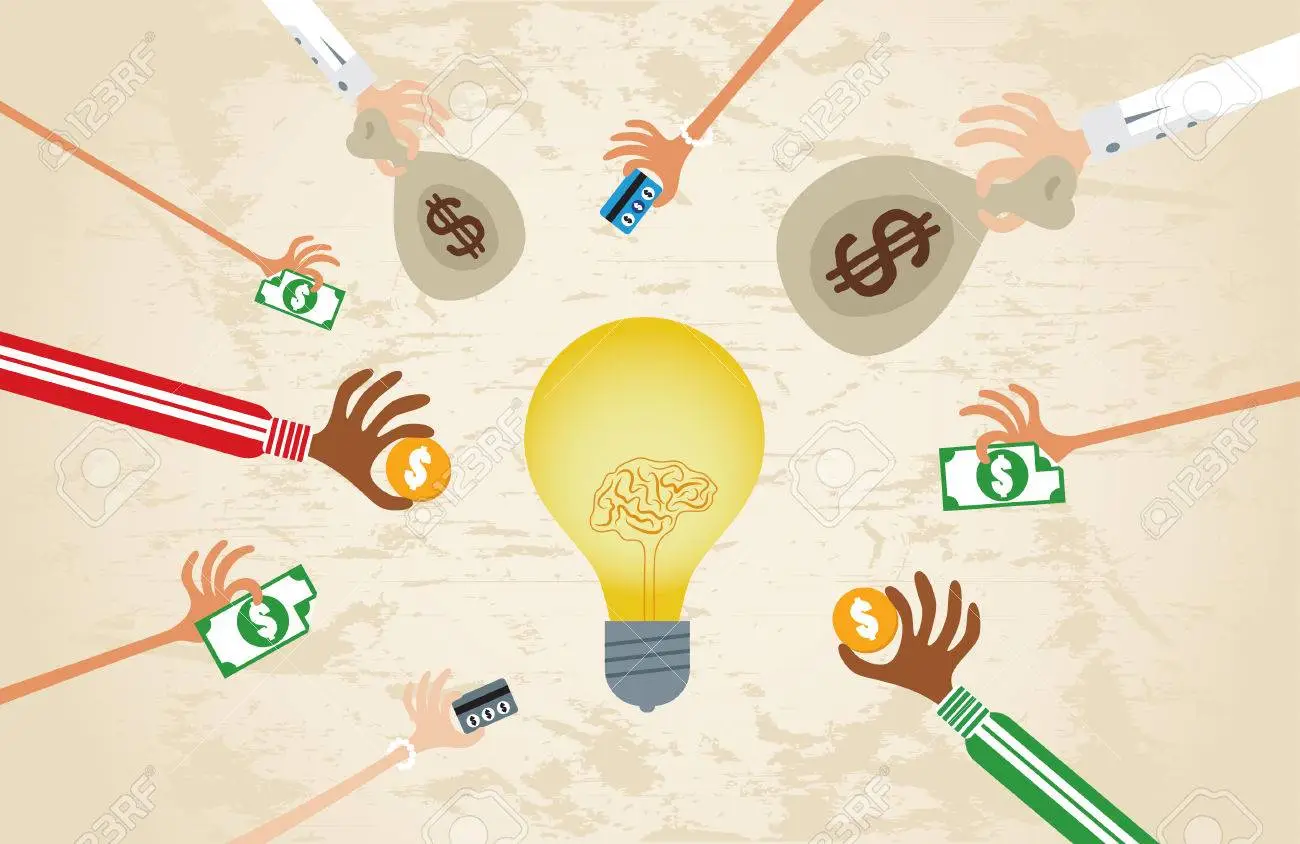

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from wordcloud import WordCloud, STOPWORDS

from os import path, getcwd
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

color = sns.color_palette()

import dataprep.eda as dp

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

NumExpr defaulting to 4 threads.


In [3]:
df = pd.read_pickle('C:\\Users\\user\\BIG DATA\\ABSCHLUSS PROJEKT\\project_darlehenpre')

## EDA und Fragen

### Wie sieht die Beziehung zwischen numerischen Variablen aus?

In [4]:
df.columns

Index(['funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'currency', 'term_in_months', 'lender_count',
       'repayment_interval', 'borrower_count', 'female_borrowers_count',
       'male_borrowers_count', 'term_in_years', 'Zielerreichungsstatus'],
      dtype='object')

In [5]:
df_numeric = df[["funded_amount","loan_amount","term_in_months","borrower_count","female_borrowers_count","lender_count"]]

In [6]:
import plotly.figure_factory as ff

df_corr = df_numeric.corr() # Generate correlation matrix

x = list(df_corr.columns)
y = list(df_corr.index)
z = np.array(df_corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.show()

<span style='color:red'>Zwischen "Funded Amount" und "Anzahl der Kreditgeber" besteht ein positiver und starker Zusammenhang.</span>

### Wie erfolgreich ist unsere Plattform?

In [7]:
df_ziel = df.groupby(['Zielerreichungsstatus'], as_index=False).agg(anzahl=('Zielerreichungsstatus','count'))
df_ziel

Zielerreichungsstatus  anzahl
0                  Nein   47646
1                    ja  619338

In [8]:
fig = px.pie(df_ziel, values='anzahl', names='Zielerreichungsstatus', color='Zielerreichungsstatus',title="Erfolgstatus",
             color_discrete_map={'Nein':'salmon',
                                 'Ja':'darkblue'})
fig.show()

<span style='color:red'>Man kann sagen, dass wir ein erfolgreiches Geschäftsmodell haben.</span>

<span style='color:red'>**Erfolgstatus nach Sektor**</span>

In [9]:
a = df[df["Zielerreichungsstatus"]=="ja"].groupby("sector").size()
b= df.groupby("sector").size()

df_x = pd.concat([b, a, round((a/b*100),1)], axis=1).rename(columns={0:"Anzahl_der_Projekte", 1:'Anzahl_der_Ziel_erreichten_Projekte', 2:'Percentage (%)'}).reset_index().sort_values('Percentage (%)', ascending=False)
df_x.sort_values('Percentage (%)', ascending=False)

sector  Anzahl_der_Projekte  Anzahl_der_Ziel_erreichten_Projekte  \
9    Manufacturing                 6158                                 6115   
1             Arts                11994                                11802   
4        Education                30837                                30073   
14       Wholesale                  626                                  606   
10    Personal Use                36247                                34804   
3     Construction                 6194                                 5873   
6             Food               135749                               127798   
7           Health                 9172                                 8563   
0      Agriculture               179224                               165602   
11          Retail               123758                               113601   
12        Services                44699                                40888   
2         Clothing                32480                                29547   
13  Transportation                15455                                13748   
8          Housing                33571                                29601   
5    Entertainment                  820                                  717   

    Percentage (%)  
9             99.3  
1             98.4  
4             97.5  
14            96.8  
10            96.0  
3             94.8  
6             94.1  
7             93.4  
0             92.4  
11            91.8  
12            91.5  
2             91.0  
13            89.0  
8             88.2  
5             87.4

In [10]:
my_bar = px.bar(data_frame=df_x,
                x='sector',
                y='Percentage (%)',
                title='Erfolgsquote nach Sektor',height=600, width=750,
                color='Percentage (%)'
               )
fig.update_layout(xaxis_tickangle=-75)
my_bar.show()

### Wie unterscheidet sich die Anzahl der Kreditnehmer je nach Sektor und Geschlecht?

In [11]:
df10 = df.groupby(["sector"],as_index=False).agg(female=("female_borrowers_count","sum"),male=("male_borrowers_count","sum"))

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Frauen', x=df10["sector"], y=df10["female"]),
    go.Bar(name='Männer', x=df10["sector"], y=df10["male"])
])
# Change the bar mode
fig.update_layout(barmode='group')

fig.update_layout(xaxis_tickangle=-60)
fig.update_layout(title_text='Anzahl der borrower nach Sektor und Geschlecht')
fig.show()

<span style='color:red'>Die Top-3-Sektoren, in denen Männer als Kreditnehmer die meisten Schulden aufnehmen, sind **"Agriculture"**, **"Food"** und **"Personal Use"**, während Frauen **"Food"**, **"Agriculture"** und **"Retail"** sind.</span>

### Welche Länder werden am meisten finanziell unterstützt??

In [13]:
fig = px.sunburst(df, path=["country"],
                 values="funded_amount",
                 color = "country")
fig.show()

### Was sind die Merkmale von nicht unterstützten Projekten?

In [14]:
df_1 = df.loc[df["funded_amount"]==0].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["funded_amount"].size()

In [15]:
df_nicht_unt = df.loc[df["funded_amount"]==0].groupby(["country","sector"],as_index=False)["loan_amount"].size()

In [16]:
fig = px.sunburst(df_1, path=["country","sector"],
                 values="size",
                 color = "country")
fig.show()

<span style='color:red'>Die am meisten nicht unterstützten Projekte befinden sich in den **"United States"** und in den Sektoren **"Services"** und **"Retail"**.</span>

<span style='color:red'>Schauen wir uns Amerika genauer an.</span>

In [17]:
df_2 = df.loc[(df["funded_amount"]>0)&(df["country"]=='United States')].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["loan_amount"].size()
df_3 = df.loc[(df["funded_amount"]==0)&(df["country"]=='United States')].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["loan_amount"].size()

In [18]:
df_USA = df.loc[(df["country"]=="United States")&(df["funded_amount"]>0)]
df_USA_nicht = df.loc[(df["country"]=="United States")&(df["funded_amount"]<=0)]
df_2 = df_USA.groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["loan_amount"].size()
df_3 = df_USA_nicht.groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["loan_amount"].size()

In [19]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_2["repayment_interval"], values=df_2["size"], name="unterstützte Projekte"),
              1, 1)
fig.add_trace(go.Pie(labels=df_3["repayment_interval"], values=df_3["size"], name="nicht unterstützte Projekte"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Die unterstützten und nicht unterstützten Projekte auf USA-Basis nach Rückzahlungsmethode",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='unterstützt', x=0.17, y=0.5, font_size=13, showarrow=False),
                 dict(text='nicht unterstützt', x=0.85, y=0.5, font_size=13, showarrow=False)])
fig.show()

In [21]:
df_6 = df.loc[df["funded_amount"]>0,:].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["loan_amount"].size()
df_7 = df.loc[df["funded_amount"]==0,:].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["loan_amount"].size()

<span style='color:red'>Es ist ersichtlich, dass die Rückzahlungsmethode aller nicht unterstützten Projekte in "United States" **"Bullet"** ist.</span>

<span style='color:red'>**Gilt das nur für die USA oder ist das für alle Länder gleich?**</span>

In [22]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_6["repayment_interval"], values=df_6["size"], name="unterstützte Projekte"),
              1, 1)
fig.add_trace(go.Pie(labels=df_7["repayment_interval"], values=df_7["size"], name="nicht unterstützte Projekte"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Die unterstützten und nicht unterstützten Projekte nach Rückzahlungsmethode",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='unterstützt', x=0.17, y=0.5, font_size=13, showarrow=False),
                 dict(text='nicht unterstützt', x=0.85, y=0.5, font_size=13, showarrow=False)])
fig.show()

<span style='color:red'>Es zeigt sich, dass die Zahlungsmethode „Bullet“ im Allgemeinen nicht bevorzugt wird, dies ist jedoch in den USA deutlicher.</span>

In [24]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_6["term_in_years"], values=df_6["size"], name="unterstützte Projekte"),
              1, 1)
fig.add_trace(go.Pie(labels=df_7["term_in_years"], values=df_7["size"], name="nicht unterstützte Projekte"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Unterstützten und nicht unterstützten Projekte nach Projektdauer",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='unterstützt', x=0.17, y=0.5, font_size=13, showarrow=False),
                 dict(text='nicht unterstützt', x=0.85, y=0.5, font_size=13, showarrow=False)])
fig.show()

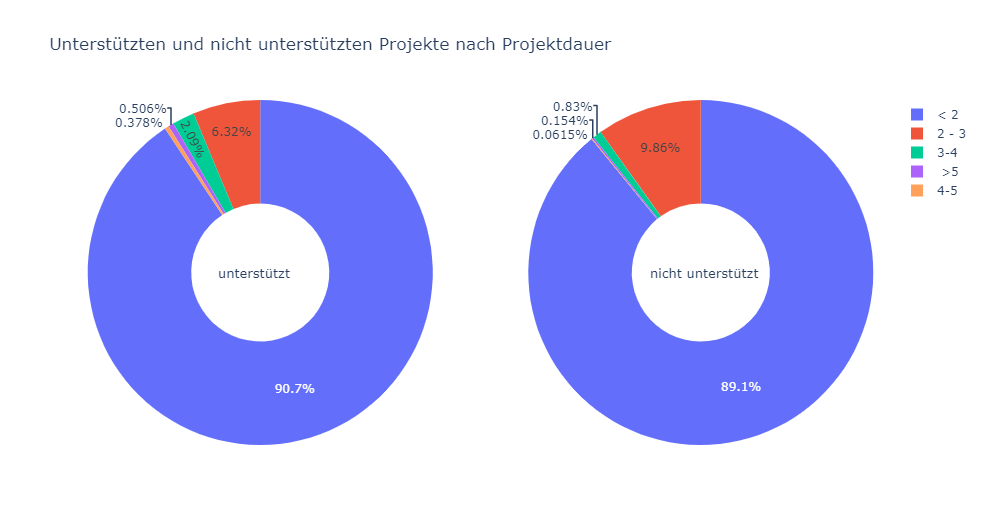

In [26]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_6["sector"], values=df_6["size"], name="unterstützte Projekte"),
              1, 1)
fig.add_trace(go.Pie(labels=df_7["sector"], values=df_7["size"], name="nicht unterstützte Projekte"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Unterstützten und nicht unterstützten Projekte nach Sektoren",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='unterstützt', x=0.17, y=0.5, font_size=13, showarrow=False),
                 dict(text='nicht unterstützt', x=0.85, y=0.5, font_size=13, showarrow=False)])
fig.show()

In [28]:
#df_4 und df_5 wird nach "borrower_count" berechnet.
df_8 = df.loc[(df["funded_amount"]>0)&(df["country"]=='United States')].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["borrower_count"].sum()
df_9 = df.loc[(df["funded_amount"]==0)&(df["country"]=='United States')].groupby(["country","sector","repayment_interval","term_in_months","term_in_years"],as_index=False)["borrower_count"].sum()


In [29]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_8["sector"], values=df_8["borrower_count"], name="unterstützte Projekte"),
              1, 1)
fig.add_trace(go.Pie(labels=df_9["sector"], values=df_9["borrower_count"], name="nicht unterstützte Projekte"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Unterstützten und nicht unterstützten Projekte nach Anzahl der Kreditnehmer",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='unterstützt', x=0.17, y=0.5, font_size=13, showarrow=False),
                 dict(text='nicht unterstützt', x=0.85, y=0.5, font_size=13, showarrow=False)])
fig.show()

<span style='color:red'> Erfolgsqueto nach Sektoren</span>

In [31]:
a = df[df["Zielerreichungsstatus"]=="ja"].groupby("sector").size()
b= df.groupby("sector").size()

df_x = pd.concat([b, a, round((a/b*100),1)], axis=1).rename(columns={0:"Anzahl_der_Projekte", 1:'Anzahl_der_Ziel_erreichten_Projekte', 2:'Percentage (%)'})
df_x.sort_values('Percentage (%)', ascending=False)

Anzahl_der_Projekte  Anzahl_der_Ziel_erreichten_Projekte  \
sector                                                                     
Manufacturing                  6158                                 6115   
Arts                          11994                                11802   
Education                     30837                                30073   
Wholesale                       626                                  606   
Personal Use                  36247                                34804   
Construction                   6194                                 5873   
Food                         135749                               127798   
Health                         9172                                 8563   
Agriculture                  179224                               165602   
Retail                       123758                               113601   
Services                      44699                                40888   
Clothing                      32480                                29547   
Transportation                15455                                13748   
Housing                       33571                                29601   
Entertainment                   820                                  717   

                Percentage (%)  
sector                          
Manufacturing             99.3  
Arts                      98.4  
Education                 97.5  
Wholesale                 96.8  
Personal Use              96.0  
Construction              94.8  
Food                      94.1  
Health                    93.4  
Agriculture               92.4  
Retail                    91.8  
Services                  91.5  
Clothing                  91.0  
Transportation            89.0  
Housing                   88.2  
Entertainment             87.4

### Wie lange dauert die Fertigstellung von Projekten auf Sektor Basis?

In [32]:
df_unt = df.groupby(["country","sector","repayment_interval","term_in_years","Zielerreichungsstatus"],as_index=False)["loan_amount"].size()

In [33]:
fig = px.treemap(df_unt, path=["sector", "term_in_years"],
                 values="size",
                 color = "term_in_years"
                )
fig.update_traces(root_color="gray")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

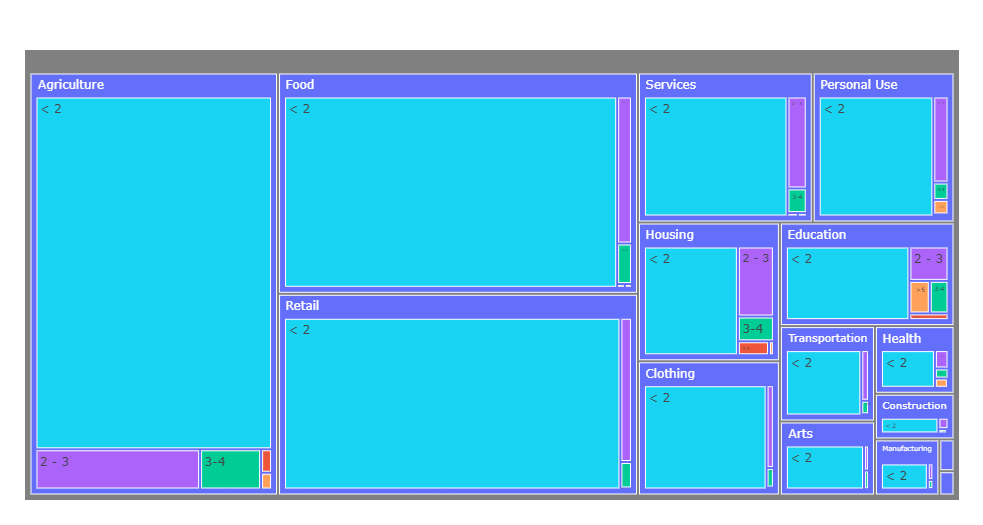

### Für welche Zwecke werden am häufigsten Kredite aufgenommen?

In [35]:
# Wir verwenden die Funktion set, um alle redundanten Stoppwörter zu entfernen

stopwords = set(STOPWORDS)
stopwords.update(['stock','items','sale','etc','pair','kg','buy','sell', 'pay', 'purchase','business','item'])

<span style='color:red'> ein Wortwolkenobjekt instanziieren</span>

In [36]:
# instantiate a word cloud object

d = getcwd()
#mask = np.array(Image.open(path.join(d, "circle.png")))

use_wordcloud = WordCloud(
    background_color='white',
  #  colormap='tab20c',
    max_words=200,
    stopwords=stopwords
)

In [37]:
# zum Vergleichen

focus_countries_2 = ['Pakistan','China','Ecuador','India']

texts_list_2 = []

for i, elem in enumerate(focus_countries_2):
    name_text = elem.join('_text')
    name_text = ' '.join(df.loc[df['country']==elem,'use'])
    texts_list_2.append(name_text)

fig, axs = plt.subplots(1,4, figsize=(20,18)) 

for i, country in enumerate(focus_countries_2):
    use_wordcloud.generate(texts_list_2[i])
    axs[i].imshow(use_wordcloud, interpolation='bilinear')
    axs[i].set_title(f'\n{country}\n', fontsize=18, color='darkblue')
    axs[i].axis('off')

#plt.savefig('word_clouds.png')    
plt.show()

## Aussage 

    - Wir können sagen, dass unser Geschäftsmodell mit einer Erfolgsquote von 92 % erfolgreich ist.
    
    - Die Erfolgsquote bezogen auf den Sektor liegt zwischen 99,3% und 87,4% und die Top 3 Sektoren mit der höchsten Erfolgsquote sind „Manifacturing“, „Arts“ und „Education“. Im Sektor „Agriculture“, wo die Anzahl der Projekte am höchsten ist, liegt diese Quote bei 92,4 %.
    
     - Die Mehrheit der Kreditnehmer sind Frauen und die 3 Top Sektoren, in denen die Frauen Kreditnehmer sind, sind "Agriculture", "Food" und "Personal Use", während für Männer "Food", "Agriculture" und "Retail" sind.
     
     - Die Fertigstellungszeit des Projekts unterscheidet sich nach Sektoren nicht wesentlich.
     
     - Die United States nehmen den ersten Platz unter den Ländern ein, deren Projekt nicht unterstützt wird und die Rückzahlungsmethode aller nicht unterstützten Projekte "Bullet" ist . Es scheint ein wichtiger Punkt für potenzielle Kunden in United States zu sein.   

In [39]:
df.to_pickle('C:\\Users\\user\\BIG DATA\\ABSCHLUSS PROJEKT\\project_darlehenlast_')